<a href="https://colab.research.google.com/github/Ranjeet-Patil-19/liver-cirrhosis/blob/main/liver_Chriss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
file_path = 'liver_cirrhosis.csv'
data = pd.read_csv(file_path)


In [3]:
# Display basic dataset information
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())



Dataset Head:
   N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   

   Platelets  Prothrombin  Stage  
0      256.0          9.9

In [5]:
# Encode categorical variables
categorical_features = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le



In [6]:
# Define features (X) and target (y)
X = data.drop(columns=['Stage'])
y = data['Stage']


In [7]:
# Scale numerical features
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])


In [8]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [10]:
# Train a Random Forest Classifier with hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [11]:
# Initialize Random Forest model and perform hyperparameter tuning using GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [12]:
# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_


In [13]:
# Train Gradient Boosting Model for comparison
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [14]:
# Evaluate the models and print metrics
models = {'Random Forest': best_rf_model, 'Gradient Boosting': gb_model}

for name, model in models.items():
    print(f"\n{name} Model Evaluation:")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))



Random Forest Model Evaluation:
Confusion Matrix:
[[1636   77   23]
 [  38 1587   44]
 [  24   39 1597]]
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.94      0.95      1736
           2       0.93      0.95      0.94      1669
           3       0.96      0.96      0.96      1660

    accuracy                           0.95      5065
   macro avg       0.95      0.95      0.95      5065
weighted avg       0.95      0.95      0.95      5065

Accuracy Score: 0.9516288252714709
ROC-AUC Score: 0.9929877622062996

Gradient Boosting Model Evaluation:
Confusion Matrix:
[[1416  250   70]
 [ 107 1454  108]
 [  75  150 1435]]
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.82      0.85      1736
           2       0.78      0.87      0.83      1669
           3       0.89      0.86      0.88      1660

    accuracy                           0.85      5065
   macro avg    

In [ ]:
# Visualize feature importance for Random Forest model
feature_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(12, 8))
feature_importance.head(10).plot(kind='bar', title='Top 10 Feature Importances', color='skyblue')
plt.ylabel('Importance')
plt.show()


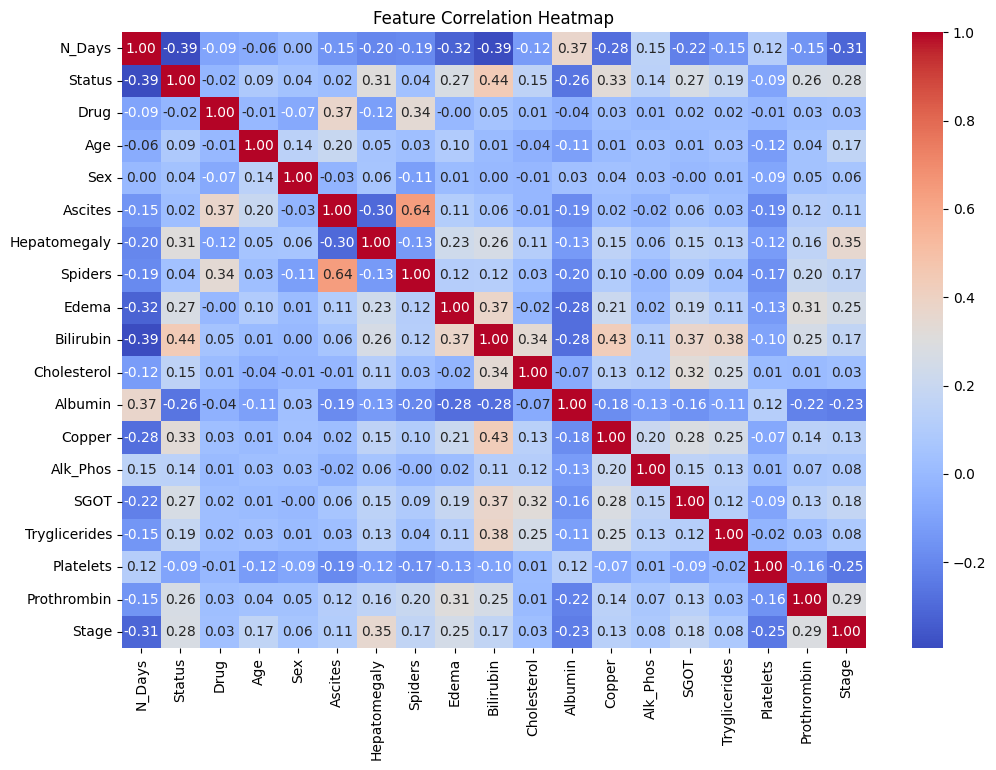

In [16]:
# Correlation Heatmap to analyze relationships between features
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [17]:
# Explainability with SHAP (using the best Random Forest model)
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)


In [ ]:
# SHAP Dependence Plot for a Key Feature to understand its relationship with predictions
shap.dependence_plot("Bilirubin", shap_values[1], X_test, feature_names=X.columns)



In [19]:
# Save the best model using joblib for persistence
import joblib
joblib.dump(best_rf_model, 'best_rf_liver_cirrhosis_model.pkl')

print("Model saved successfully as 'best_rf_liver_cirrhosis_model.pkl'")


Model saved successfully as 'best_rf_liver_cirrhosis_model.pkl'
